In [1]:
import numpy as np
from moviepy.editor import *
import soundfile as sf

In [2]:
# %load hparams.py
from argparse import ArgumentParser
from typing import NamedTuple

class HParams(NamedTuple):
    temporal_dim: int = 75
    frame_overlap: int = 10
    sr: int = 16000
    n_mels: int = 80
    n_fft: int = 1280
    hop_length: int = 640
    fps: int = 25
    f_max: int = 8000
    w: int = 96
    h: int = 96
    dataset_batch_size: int = 1
    batch_size: int = 32
    data_dir: str = "data"
    checkpoint_dir: str = "checkpoints"
    epochs: int = 1000
    learning_rate: float = 1e-3
    train_test_ratio: float = 0.9
    batch_log: int = 50
    dataset_ratio: float = 1.0
    cache_data: bool = True
    save_every: int = 100
    teacher_forcing_ratio: float = 0.5
    codec: str = 'pcm_s16le'

    teacher_forcing_ratio: float = 0.5

    prenet_dim: int = 128
    postnet_dim: int = 512
    postnet_kernel_size: int = 5
    postnet_n_convs: int = 5
    postnet_dropout: float = 0.5

    attn_hidden_size: int = 1024
    attn_dim: int = 128
    attn_n_filters: int = 32
    attn_kernel_size: int = 31

    encoder_layers: int = 2
    encoder_hidden_size: int = 256

    decoder_hidden_size: int = 1024

    min_level_db: float = -100.
    ref_level_db: float = 20.
    max_abs_value: float = 4.

    dropout: float = 0.1

def do_arg_parse_with_hparams(parser: ArgumentParser):
    default_hparams = HParams()

    fields = default_hparams._asdict().keys()
    for field in fields:
        default_value = getattr(default_hparams, field)
        parser.add_argument(f"--{field}", default=default_value, required=False, type=type(default_value))

    args = parser.parse_args()

    hparams = HParams(*[getattr(args, field) for field in fields])
    return args, hparams


In [3]:
# %load dataset.py
import os
import os.path
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
import librosa

from hparams import HParams

class MerkelDataset(Dataset):
    def __init__(self, hparams: HParams):
        self.hparams = hparams
        self.filepaths = []
        self.cached_batches = {}
        for f in os.listdir(self.hparams.data_dir):
            if f.startswith("batch") and f.endswith('.npz'):
                self.filepaths.append(os.path.join(self.hparams.data_dir, f))

    def __len__(self):
        return int(len(self.filepaths) * self.hparams.dataset_ratio) * self.hparams.dataset_batch_size 

    def get_batch(self, file_idx):
        if file_idx in self.cached_batches:
            return self.cached_batches[file_idx]

        data = np.load(self.filepaths[file_idx], allow_pickle=True)
        X = data['X']
        Y = data['Y']

        self.cached_batches[file_idx] = (X, Y)

        return (X, Y)

    def __getitem__(self, idx):
        file_idx = idx // self.hparams.dataset_batch_size 
        data_idx = idx % self.hparams.dataset_batch_size 

        (X, Y) = self.get_batch(file_idx)

        x = X[data_idx]
        y = Y[data_idx]

        return x, y

    def preload(self):
        len_batches = len(self)//self.hparams.dataset_batch_size
        with tqdm(total=len_batches, unit="batch") as pbar:
            pbar.set_description("Preloading dataset into memory")
            for i in range(len_batches):
                self.get_batch(i)
                pbar.update(1)

def normalize(S, hparams: HParams):
    S_db = librosa.power_to_db(S) - hparams.ref_level_db
    return np.clip((2*hparams.max_abs_value)*((S_db - hparams.min_level_db) / (-hparams.min_level_db)) - hparams.max_abs_value, -hparams.max_abs_value, hparams.max_abs_value)

def denormalize(D, hparams: HParams):
    D = (((np.clip(D, -hparams.max_abs_value, hparams.max_abs_value) + hparams.max_abs_value) * -hparams.min_level_db / (2 * hparams.max_abs_value)) + hparams.min_level_db)
    D = librosa.db_to_power(D + hparams.ref_level_db)
    return D

In [25]:
import random
hparams = HParams()
path = random.choice(os.listdir(hparams.data_dir))
print(path)
data = np.load(os.path.join(hparams.data_dir, path))
X = data['X']
Y = data['Y']

X.shape, Y.shape

batch_1_0.npz


((64, 3, 75, 96, 96), (64, 75, 80))

In [26]:
x = X[0]
x = x * 255.0
x = x.astype(int)
y = Y[0]
# C, T, H, W -> T, H, W, C
x = x.transpose(1, 2, 3, 0)
x.shape

(75, 96, 96, 3)

In [27]:
import matplotlib.pyplot as plt

def example_to_video(x, y):
    x = x * 255.0
    x = x.astype(int)
    # C, T, H, W -> T, H, W, C
    x = x.transpose(1, 2, 3, 0)
    video = concatenate([ImageClip(f).set_duration(1/25.0) for f in x])

    S = y.transpose(1, 0)
    S = denormalize(S, hparams)
    linear_segment = librosa.feature.inverse.mel_to_stft(S, sr=hparams.sr, n_fft=hparams.n_fft)
    audio_griffin = librosa.griffinlim(linear_segment, n_iter=32, hop_length=hparams.hop_length)  # Adjust n_iter as needed
    # Save to WAV file
    sf.write('/tmp/output.wav', audio_griffin, hparams.sr)
    video.audio = AudioFileClip('/tmp/output.wav')

    # Convert to dB
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot Mel Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=16000, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

    return video

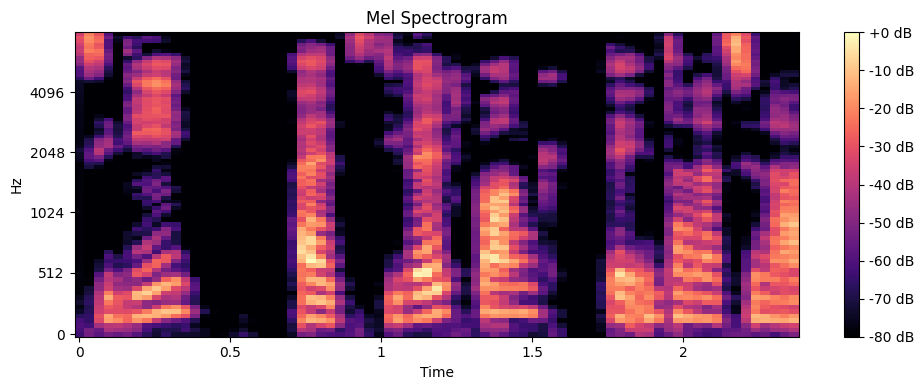

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [29]:
video = example_to_video(X[10], Y[10])
video.ipython_display(width=360, fps=25)

In [14]:
video = example_to_video(X[1], Y[1])
video.ipython_display(width=360, fps=25)

IndexError: index 1 is out of bounds for axis 0 with size 1